# Differences-in-Differences models
`2020-11-24`

_Zhiyuan Chen, Department of Trade Economics, Renmin Business School_

## An overview

### Difference-in-Difference model

#### Benchmark model
The DGP for the DID estimator can be written as 
$$
y_{it} = \alpha_0 +\alpha \tau_{it}  + X_{it}'\beta+\delta t +\theta_i +\epsilon_{it} \tag{1}
$$
where $\tau_{it}=1$ if $t\geq t_0$ and $i$ is in the treated group. This is also called the _two-way fixed effects model_. 

#### Dynamic treatment effects
The baseline model can be easily extend to allow for dynamic treatment effects:
$$
y_{it} = \beta_0 +\sum_{j=0}^J\alpha_j\tau_{t-j}^{g_{i}}+\delta t +\theta_i +\epsilon_{it} \tag{2}
$$
### Inference: Cluster-Robust standard errors
Consider the model:

$$
y_{itg} = \alpha_0 + \alpha\tau_{itg}+ X_{itg}'\beta + \theta_i + \delta t + \epsilon_{itg} \tag{3}
$$
where $g$ represent the _group_ indicator that individual $i$ belongs to. In practice, $g$ can be village, county, industry, province, state, nation, etc. The problem is how to get the correct standard errors. Bertrand, Duflo, and Mullainanthan (2004) illustrates the importance of clustering standard errors at the state-level when the policy intervention is enacted at the state level. 

Note that <u>including fixed effects generally does NOT control for all the within-cluster correlation of the error and one should still use the Cluster-Robust Variance Estimator</u> (Cameron and Miller, 2015). 

In Stata, the cluster-robust standard error for FE estimator can be obtained via:

* `xtreg y x, fe vce(robust)` clusters at _individual-level_
* `xtreg y x, fe vce(cluster id_g)` clusters at _group-level_

Sometimes the cluster-robust variance estimates is not available, we can use bootstrap to obtain a consistent estimate of the variance. This can be done using bootstrap method:

* `xtreg y x, fe vce(boot, reps(400) seed(10101))`

#### Choosing the appropriate level to cluster
According to Cameron and Miller (2015), there are two guiding principles:
1. We should think about clustering at the level whenever we believe that both the regressors and the errors might be correlated within the cluster;
2. If we define very large clusters, there are very few clusters to average over. This results in a poor estimate of the variance. 

As in many estimation problems, we face a bias-variance tradeoff--larger and fewer clusters have less bias but more variability. 

In practice, researcher often cluster at progressively higher levels and stop clustering when there is relatively little change in the standard errors. 
#### Dealing with Few Clusters
First, there is no clear-cut definition of "few". "Few" may range from less than 20 clusters to less than 50 clusters in the balanced case and even more in the unbalanced cased. Few clusters leads to two problems:
1. A downward-biased cluster-robust variance matrix estimate for the error
2. An overrejection (confidence intervals are too narrow) for coefficient estimates

The first-best solution is to collect more data. If we are too lazy to do that, several solutions are handy if we face the problem of few clusters. You are strongly recommended to read Bertrand Duflo and Mulainathan (2004, Section IV), Section VI in Cameron and Miller (2015) and Chapter 8 of Angrist and Pischke (2009) for more details.


### Event studies for the placebo policies
As a robustness check, we usually pretend the policy is enacted at some time earlier than the actual adoption time to validate the common trend assumption. We can run a regression like:
$$
y_{it} = \beta_0 + \sum_{j=-J_0,j\neq-1}^{J}\alpha_j\tau_{it-j} +\delta t +\theta_i +\varepsilon_{it}
$$
where $\tau_{it-j} = 1$ if $t_i-j=0$ and $i$ is in the treated group.

# Stata Examples for Diff-in-Diff

In [1]:
* An Example of Diff-in-Diff (Based on "http://www.princeton.edu/~otorres/DID101.pdf")
clear all
set more off
qui use Panel101.dta,clear //or you may type "use "http://dss.princeton.edu/training/Panel101.dta", clear

In [2]:
describe


Contains data from Panel101.dta
  obs:            70                          
 vars:             9                          3 Jan 2020 11:28
 size:         2,660                          
--------------------------------------------------------------------------------
              storage   display    value
variable name   type    format     label      variable label
--------------------------------------------------------------------------------
country         long    %14.0g     country    Country
year            int     %8.0g                 Year
y               double  %10.0g                Outcome Y
y_bin           float   %9.0g                 Binary outcome Y
x1              float   %9.0g                 Predictor x1
x2              float   %9.0g                 Predictor x2
x3              float   %9.0g                 Predictor x3
opinion         float   %18.0g     agree      Categorical variable
op              float   %9.0g                 
-------------------------------

In [3]:
summarize


    Variable |        Obs        Mean    Std. Dev.       Min        Max
-------------+---------------------------------------------------------
     country |         70           4    2.014441          1          7
        year |         70      1994.5     2.89302       1990       1999
           y |         70    1.85e+09    3.02e+09  -7.86e+09   8.94e+09
       y_bin |         70          .8    .4028881          0          1
          x1 |         70    .6480006      .46807  -.5675749   1.446412
-------------+---------------------------------------------------------
          x2 |         70    .1338694    1.371099  -1.621761   2.530277
          x3 |         70     .761851    1.446332  -1.165387   7.168922
     opinion |         70    2.442857    1.137448          1          4
          op |         70          .5    .5036102          0          1


In [6]:
* Generate time and treated variables
drop if missing(year)&missing(country)
qui gen time = (year>=1994)
qui gen treated = (country>4)
qui g lny = log(y)
qui gen tau = time*treated  //interaction between group dummy and time dummy


(0 observations deleted)

variable time already defined


r(110);
r(110);


In [7]:
reg y tau treated time, r


Linear regression                               Number of obs     =         70
                                                F(3, 66)          =       2.17
                                                Prob > F          =     0.0998
                                                R-squared         =     0.0827
                                                Root MSE          =     3.0e+09

------------------------------------------------------------------------------
             |               Robust
           y |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
         tau |  -2.52e+09   1.45e+09    -1.73   0.088    -5.42e+09    3.81e+08
     treated |   1.78e+09   1.05e+09     1.70   0.094    -3.11e+08    3.86e+09
        time |   2.29e+09   9.00e+08     2.54   0.013     4.92e+08    4.09e+09
       _cons |   3.58e+08   7.61e+08     0.47   0.640    -1.16e+09    1.88e+09
-------------

In [8]:
* regression using hashtag
reg y time##treated, r


Linear regression                               Number of obs     =         70
                                                F(3, 66)          =       2.17
                                                Prob > F          =     0.0998
                                                R-squared         =     0.0827
                                                Root MSE          =     3.0e+09

------------------------------------------------------------------------------
             |               Robust
           y |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
      1.time |   2.29e+09   9.00e+08     2.54   0.013     4.92e+08    4.09e+09
   1.treated |   1.78e+09   1.05e+09     1.70   0.094    -3.11e+08    3.86e+09
             |
time#treated |
        1 1  |  -2.52e+09   1.45e+09    -1.73   0.088    -5.42e+09    3.81e+08
             |
       _cons |   3.58e+08   7.61e+08     0.47  

In [10]:
* for logged model
reg lny tau treated time, r


Linear regression                               Number of obs     =         56
                                                F(3, 52)          =       0.38
                                                Prob > F          =     0.7677
                                                R-squared         =     0.0238
                                                Root MSE          =     1.3179

------------------------------------------------------------------------------
             |               Robust
         lny |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
         tau |  -.5524526   .8683878    -0.64   0.527       -2.295    1.190095
     treated |   .2565522   .7679171     0.33   0.740    -1.284386    1.797491
        time |   .5730012   .7430261     0.77   0.444    -.9179898    2.063992
       _cons |   20.98152   .6992099    30.01   0.000     19.57845    22.38459
--------------

In [13]:
* FE estimator: two-way fixed effects model
qui xtreg y tau time, fe 
est sto fe_iid
qui xtreg y tau time, fe vce(robust)  // too few clusters that may lead to problem
est sto fe_clu
est table fe_iid fe_clu, b se b(%9.4f) stats(N r2 r2_o r2_b r2_w simga_u sigma_e rho)







--------------------------------------
    Variable |  fe_iid      fe_clu    
-------------+------------------------
         tau | -2.52e+09   -2.52e+09  
             |  1.37e+09    1.02e+09  
        time |  2.29e+09    2.29e+09  
             |  8.99e+08    6.31e+08  
       _cons |  1.12e+09    1.12e+09  
             |  5.26e+08    2.99e+08  
-------------+------------------------
           N |        70          70  
          r2 |    0.0968      0.0968  
        r2_o |    0.0341      0.0341  
        r2_b |    0.0116      0.0116  
        r2_w |    0.0968      0.0968  
     simga_u |                        
     sigma_e |  2.78e+09    2.78e+09  
         rho |    0.2518      0.2518  
--------------------------------------
                          legend: b/se


In [43]:
*Placebo polices and event study
g y_norm = y/1e12  //normalize the data for a better view
forv s = -4(1)5 {
    if `s'<0 {
        local i = -`s'
        qui gen tau_`i' = treat*(year>=(1994+`s'))
        }
    else if `s'==0 {
        continue 
        }
    else if `s'>0 {
        qui gen tau`s' = treat*(year>=(1994+`s'))
        }
}

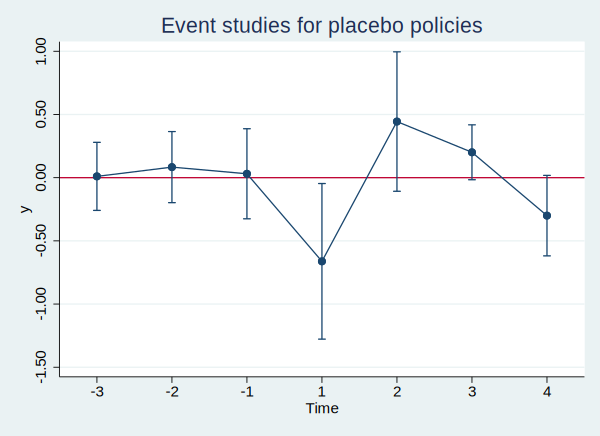

In [84]:
qui reg y_norm tau_3 tau_2 tau_1 tau1 tau2 tau3 tau4 time treat, r
coefplot, keep(tau*) ///
          coeflabels(tau_3 = "-3" tau_2 = "-2" tau_1 = "-1" tau1 = "1" tau2 = "2" tau3 = "3" tau4 = "4") ///
          ciopt(recast(rcap))  /// rarea, rbar, rspike, rline...see help file for more
          rescale(100) format(%9.2f) ///
          recast(connected)  ///
          vertical yline(0) ytitle(y) xtitle("Time") title("Event studies for placebo policies") ///

         // addplot(line @b @at)
          

In [80]:
*Dynamic Treatment effects
reg y tau1 tau2 tau3 tau4 time treat, r


Linear regression                               Number of obs     =         70
                                                F(6, 63)          =       4.34
                                                Prob > F          =     0.0010
                                                R-squared         =     0.2046
                                                Root MSE          =     2.8e+09

------------------------------------------------------------------------------
             |               Robust
           y |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
        tau1 |  -6.19e+09   2.73e+09    -2.26   0.027    -1.16e+10   -7.27e+08
        tau2 |   4.44e+09   2.69e+09     1.65   0.104    -9.39e+08    9.82e+09
        tau3 |   2.01e+09   1.06e+09     1.89   0.063    -1.10e+08    4.13e+09
        tau4 |  -3.00e+09   1.55e+09    -1.93   0.058    -6.11e+09    1.01e+08
        time 

# Cluster-Robust standard errors: views from simulations
Although a good dataset for studying the cluster-robust standard errors is not readily available, we may still use simulation techniques to understand the underlying theory of clustered standard errors. A general procedure can be found in Bertrand, Duflo, and Mullainathan (2004). 

This part will be an assignment, which essentially requires you to replicate the paper by Bertrand, Duflo, and Mullainathan (2004).This section will soon be updated after the homework is due.

# References

* Angrist, J. D., and J. S. Pischke. (2008): “Mostly harmless econometrics: An empiricist’s companion.” 
* Bertrand, M., E. Duflo, and S. Mullainathan. (2004): “How much should we trust DID?,” Quarterly Journal of Economics,  1–27.
* Colin Cameron, A., and D. L. Miller. (2015): “A practitioner’s guide to cluster- robust inference,” Journal of Human Resources, 50, 317–72.